In [1]:
from langchain_teddynote.messages import stream_graph
from langchain_core.tools import Tool
from langchain_core.vectorstores import VST
from datetime import datetime
import threading
import typing
import os
import sqlite3
from dotenv import load_dotenv
from operator import itemgetter

from langgraph.graph.state import CompiledStateGraph

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableWithMessageHistory, ConfigurableFieldSpec, RunnableConfig
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, MessagesPlaceholder
from langchain_community.chat_message_histories import ChatMessageHistory, SQLChatMessageHistory
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import MongodbLoader
from typing import Annotated
from typing_extensions import TypedDict
from langchain_teddynote.tools.tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.tools.retriever import create_retriever_tool

from utils import generate_integer_id64, compare_dicts_sorted
from server.db import DB, get_mongo_collection
from server.db import get_mongo_connection_string
from server.logger import logger

from agentic_rag import grade_documents, AgentState, rewrite, generate, agent

load_dotenv()

vectorstore_dir = "../vectorstore"

# Î™®Îì† Ï±óÎ¥áÏùò Î©îÌÉÄÎç∞Ïù¥ÌÑ∞Î•º Í∞ÄÏ†∏ÏôÄÏÑú Ï¥àÍ∏∞Ìôî.
chatbot_collection = get_mongo_collection(DB.NAME, DB.COLLECTION.CHATBOT)
chat_collection = get_mongo_collection(DB.NAME, DB.COLLECTION.CHANNEL.DATA)


########## 1. ÏÉÅÌÉú Ï†ïÏùò ##########
# ÏÉÅÌÉú Ï†ïÏùò
class State(TypedDict):
    # Î©îÏãúÏßÄ Î™©Î°ù Ï£ºÏÑù Ï∂îÍ∞Ä
    messages: Annotated[list, add_messages]

def load_chats(channel_ids:typing.Iterable[typing.Union[str, int]]):
    chats = {}
    for channel_id in channel_ids:
        # Ï±ÑÌåÖ Îç∞Ïù¥ÌÑ∞ collectionÏóêÏÑú, Ï∞∏Í≥†ÌïòÎ†§Îäî Ï±ÑÎÑêÏóêÏÑú ÏÜ°ÏàòÏã†Îêú Î™®Îì† Ï±ÑÌåÖÏùò Ï±ÑÌåÖ idÎ•º Ï±ÑÎÑê idÎ°ú ÎÇòÎàÑÏñ¥ÏÑú Ï†ÄÏû•.
        chats[channel_id] = [chat.get('id') for chat in chat_collection.find({"channelId": int(channel_id)})]
    return chats


# ÌÅ¥ÎûòÏä§ Ï†ïÏùòÍ∞Ä ÏôÑÎ£åÎêòÎäî ÏãúÏ†ê(ÌÅ¥ÎûòÏä§ ÏÑ†Ïñ∏ ÏãúÏ†ê)Ïóê ÎØ∏Î¶¨ Ïù∏Ïä§ÌÑ¥Ïä§Î•º ÏÉùÏÑ±ÌïòÎäî Î©îÌÉÄÌÅ¥ÎûòÏä§.
class AutoCreateInstances(type):
    def __init__(cls, name, bases, dct):
        super().__init__(name, bases, dct)
        # _instances Î≥ÄÏàòÎ•º Ï¥àÍ∏∞Ìôî
        cls._instances = {}
        # ÌÅ¥ÎûòÏä§Í∞Ä ÏÉùÏÑ±ÎêòÏûêÎßàÏûê Ï±óÎ¥áÏùò Î©îÌÉÄÎç∞Ïù¥ÌÑ∞Î•º Îã§Ïö¥Î°úÎìú, Ï±óÎ¥á IDÎßàÎã§ Ïù∏Ïä§ÌÑ¥Ïä§Î•º ÏÉùÏÑ±Ìï¥ÏÑú Îì±Î°ù
        for document in chatbot_collection.find():
            cls._instances[document.get('id')] = cls(bot_id=document.get('id'))

        logger.info(f"Î°úÎìúÎêú Ï±óÎ¥á: {list(cls._instances.keys())}")
            
class Watson(metaclass=AutoCreateInstances):
    prompt_template = PromptTemplate.from_template(
        """You are an AI assistant helping an investigator trying to investigate a drug-selling channel. You are specialized in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
        Your primary mission is to answer questions based on provided context or chat history.
        Provided context is chat data collected from a Telegram channel where drugs are sold.
        Ensure your response is concise and directly addresses the question without any additional narration.
        
        ###
        
        Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names), followed by the source of the information.
        
        # Steps
        
        1. Carefully read and understand the context provided.
        2. Identify the key information related to the question within the context.
        3. Formulate a concise answer based on the relevant information.
        4. Ensure your final answer directly addresses the question.
        5. List the source of the answer in bullet points, which must be a url of the document, followed by brief part of the context. Omit if the source cannot be found.
        
        # Output Format:
        [Your final answer here, with numerical values, technical terms, jargon, and names in their original language]
        
        **Source**(Optional)
        - (Source of the answer, must be a url of the document, followed by brief part of the context. Omit if you can't find the source of the answer.)
        - (list more if there are multiple sources)
        - ...
        
        ###
        
        Remember:
        - It's crucial to base your answer solely on the **PROVIDED CONTEXT**. 
        - DO NOT use any external knowledge or information not present in the given materials.
        - If you can't find the source of the answer, you should answer that you don't know.
        
        ###
        
        # Here is the user's QUESTION that you should answer:
        {question}
        
        # Here is the CONTEXT that you should use to answer the question:
        {context}
        
        # Your final ANSWER to the user's QUESTION:"""
    )

    _instances = {}
    _session_history = {}  # ÏÑ∏ÏÖò Í∏∞Î°ùÏùÑ Ï†ÄÏû•Ìï† ÎîïÏÖîÎÑàÎ¶¨
    _lock = threading.Lock()
    _sqlalchemy_connection_string = f"sqlite:///{os.path.dirname(vectorstore_dir)}/chats.db"
    _sqlite_connection_string = f"{os.path.dirname(vectorstore_dir)}/chats.db"
    
    error_msg_for_empty_data = "Ï£ÑÏÜ°Ìï©ÎãàÎã§. ÏöîÏ≤≠ÌïòÏã† Ï±ÑÎÑêÏùò Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÍ±∞ÎÇò, ÏïÑÏßÅ ÏàòÏßëÎêòÏßÄ ÏïäÏïÑ ÎãµÎ≥ÄÏùÑ ÎìúÎ¶¥ Ïàò ÏóÜÏäµÎãàÎã§."
    GLOBAL = "global"
    MULTI = "multi"
    LOCAL = "local"
    
    memory = SqliteSaver(sqlite3.connect(_sqlite_connection_string, check_same_thread=False))

    def __new__(cls, bot_id:int=None, channel_ids:list=None, scope:str=None):
        """
            Ïã±Í∏ÄÌÜ§ Í∞ùÏ≤¥Ïùò Î≥ÄÌòï Íµ¨ÌòÑ.
            ÏûÖÎ†•Î∞õÏùÄ channel idÏóê ÎåÄÏùëÌïòÎäî watson Ï±óÎ¥áÏù¥ ÏóÜÏùÑ Í≤ΩÏö∞Ïóê ÌïúÌï¥,
            Í≥†Ïú†Ìïú watson Í∞ùÏ≤¥Î•º ÏÉàÎ°ú ÎßåÎì§Í≥† Î∞òÌôòÌïòÎäî ÎèôÏãúÏóê _instancesÏóê ÎÇ¥Î∂ÄÏ†ÅÏúºÎ°ú Ï†ÄÏû•ÌïúÎã§.

            ÎßåÏïΩ Ìï¥Îãπ channel idÏóê ÎåÄÏùëÌïòÎäî Ï±óÎ¥áÏù¥ Ïù¥ÎØ∏ ÏÉùÏÑ±ÎêòÏóàÏùÑ Í≤ΩÏö∞,
            Í∑∏ Ï±óÎ¥áÏùÑ Î∞òÌôòÌïúÎã§.
        """
        with cls._lock:
            if not cls._instances.get(bot_id):
                new_bot = super().__new__(cls)
                if bot_id:
                    # Ï±óÎ¥áÏùò IDÎ°ú ÏßÅÏ†ë Ï±óÎ¥áÏùÑ Ìò∏Ï∂úÌï† ÎïåÎäî, DBÏóê Ïù¥ÎØ∏ Ìï¥Îãπ Ï±óÎ¥áÏùò Ï†ïÎ≥¥Í∞Ä ÏûàÏùå.
                    if channel_ids or scope:
                        logger.warning(f"Ï∞∏Í≥†Ìï† Ï±ÑÎÑê Ï†ïÎ≥¥ ÎòêÎäî Ï∞∏Í≥† Î≤îÏúÑÎ•º ÏûÖÎ†•ÌñàÏßÄÎßå, Ï±óÎ¥á IDÎ•º ÏûÖÎ†•ÌñàÍ∏∞ ÎïåÎ¨∏Ïóê IDÎ•º Ï†úÏô∏Ìïú Ï†ïÎ≥¥Îäî Î¨¥ÏãúÎê©ÎãàÎã§. "
                                       f"Chatbot ID: {bot_id}, Channel IDs: {channel_ids}, Scope: {scope}")
                    new_bot._bot_id = bot_id
                elif channel_ids and scope: # Ï±óÎ¥áÏù¥ Ï∞∏Ï°∞ÌïòÎäî Ï±ÑÎÑê Ï†ïÎ≥¥Î°ú Ï±óÎ¥áÏùÑ Ìò∏Ï∂úÌï† ÎïåÎäî DBÏóê Ìï¥ÎãπÌïòÎäî Ï±óÎ¥áÏù¥ ÏûàÏúºÎ©¥ Î°úÎìú. ÏóÜÏúºÎ©¥ ÏÉùÏÑ±.
                    if bot_id := cls._get_bot_id(cls, channel_ids, scope):
                        # Ï±ÑÎÑê Ï†ïÎ≥¥Ïóê Ìï¥ÎãπÌïòÎäî Î¥áÏù¥ ÏûàÎã§Î©¥ Í∑∏ Î¥áÏùò idÎ•º Í∏∞Ï§ÄÏúºÎ°ú Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§ÏóêÏÑú Î°úÎìúÌïú Ï†ïÎ≥¥Î•º Í∞ÄÏßÄÍ≥† ÏÉùÏÑ±ÌïòÎèÑÎ°ù ÏöîÏ≤≠.
                        new_bot._bot_id = bot_id
                    else:
                        # Ï±ÑÎÑê Ï†ïÎ≥¥Ïóê Ìï¥ÎãπÌïòÎäî Î¥áÏù¥ ÏóÜÏúºÎ©¥ bot_idÎ•º ÏûÖÎ†•ÌïòÏßÄ ÏïäÍ≥† Ï±ÑÎÑê Ï†ïÎ≥¥Îßå ÏûÖÎ†•Ìï¥ÏÑú ÏÉàÎ°úÏö¥ Î¥áÏùÑ ÏÉùÏÑ±ÌïòÎèÑÎ°ù ÏöîÏ≤≠.
                        new_bot._bot_id = None
                else:
                    raise ValueError(f"Ï±óÎ¥áÏùÑ Ìò∏Ï∂úÌï† Îïå Ï±óÎ¥áÏùò ID ÎòêÎäî Ï±ÑÎÑê ID Î™©Î°ùÍ≥º Î≤îÏúÑ Îëò Ï§ë ÌïòÎÇòÎäî ÏûÖÎ†•Ìï¥Ïïº ÌïòÏßÄÎßå, Î™®Îëê ÏûÖÎ†•ÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§.")

                cls._instances[bot_id] = new_bot

        return cls._instances[bot_id] # Ïù¥ÎØ∏ ÏûàÍ±∞ÎÇò ÏÉùÏÑ±Îêú Î¥á Î∞òÌôò.


    def _get_bot_id(self:typing.Type['Watson'], channel_ids:list, scope:str) -> typing.Optional[int]:
        """ÏÉùÏÑ±Îêú instance Ï§ë Ï∞∏Í≥†ÌïòÎäî Ï±ÑÎÑêÏùò Î™©Î°ùÏù¥ Í∞ôÏúºÎ©¥ Ìï¥Îãπ Î¥áÏùò IDÎ•º Î∞òÌôòÌïòÎäî Î©îÏÑúÎìú."""
        for bot_id, bot_instance in self._instances.items():
            # global Ï±óÎ¥áÏùÄ ÌïòÎÇòÎßå Ïú†ÏßÄÌïòÎØÄÎ°ú scopeÍ∞Ä globalÏù¥Î©¥ global Ï±óÎ¥áÎßå Ï∞æÍ≥†, ÏïÑÎãê Í≤ΩÏö∞ÏóêÎßå channel idsÎ•º ÎπÑÍµêÌïúÎã§.
            if scope == self.GLOBAL:
                if bot_instance.scope == scope:
                    return bot_id
            elif sorted(list(bot_instance.chats.keys())) == sorted(map(str, channel_ids)):
                return bot_id
        return None


    def __init__(self, bot_id:int=None, channel_ids:list[int]=None, scope:str=None):
        try:
            with self._lock:
                # Ïù¥ÎØ∏ Í∞ùÏ≤¥Í∞Ä Ï¥àÍ∏∞ÌôîÎêòÏñ¥ ÏûàÏùÑ Í≤ΩÏö∞(chatsÍ∞Ä ÏûàÍ≥†, NoneÏù¥ ÏïÑÎãò), Í∞ùÏ≤¥Î•º Ï¥àÍ∏∞ÌôîÌïòÏßÄ ÏïäÍ≥† Î≤°ÌÑ∞Ïä§ÌÜ†Ïñ¥Îßå ÏóÖÎç∞Ïù¥Ìä∏Ìïú ÌõÑ Ï¢ÖÎ£å.
                # ÎßåÏïΩ chatsÍ∞Ä ÏïÑÎãå _bot_idÎ•º Í∏∞Ï§ÄÏúºÎ°ú ÌïúÎã§Î©¥, __new__ÏóêÏÑú _bot_idÎ•º Ï¥àÍ∏∞ÌôîÌïú ÌõÑÏóê ÎÑòÏñ¥Ïò§Í∏∞ ÎïåÎ¨∏Ïóê Ìï≠ÏÉÅ Ï∞∏Ïù¥ ÎêúÎã§.
                # ÎïåÎ¨∏Ïóê chatsÎ•º Í∏∞Ï§ÄÏúºÎ°ú Ìï¥Ïïº Ìï®.
                if getattr(self, "chats", None):
                    self._update_vectorstore()
                    return

                logger.debug(f"Î©îÎ™®Î¶¨Ïóê ÏÉàÎ°úÏö¥ Ï±óÎ¥áÏùÑ Î°úÎìúÌï©ÎãàÎã§. Chatbot ID: {self._bot_id}")
                if self._bot_id: # bot_idÍ∞Ä ÏûÖÎ†•ÎêòÏóàÏùÑ Í≤ΩÏö∞: Ïù¥ÎØ∏ DBÏóê Ï†ïÎ≥¥Í∞Ä Ï†ÄÏû•ÎêòÏñ¥ ÏûàÏúºÎØÄÎ°ú Î°úÎìú.
                    bot_info = chatbot_collection.find_one({"id": self._bot_id})
                    # Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§Ïóê idÍ∞Ä ÏóÜÏúºÎ©¥ ÏïÑÏßÅ ÏÉùÏÑ±ÌïòÏßÄ ÏïäÏùÄ Ï±óÎ¥áÏóê Ï†ëÍ∑ºÌïòÎäî Í≤ÉÏù¥ÎØÄÎ°ú Ïò§Î•ò.
                    if not bot_info:
                        raise KeyError(f"ÏÉùÏÑ±Ìïú Ï†ÅÏù¥ ÏóÜÎäî IDÎ°ú Ï±óÎ¥áÏùÑ Î∂àÎü¨Ïò§Î†§Í≥† ÏãúÎèÑÌñàÏäµÎãàÎã§. Chatbot ID: {bot_id}")
                    self.chats, self.scope = bot_info.get("chats"), bot_info.get("scope")
                else:
                    if type(channel_ids) is not list or not all([isinstance(_id, int) for _id in channel_ids]):
                        raise TypeError(f"Parameter 'channel_ids' must be list[int].")

                    self._bot_id = generate_integer_id64(existing_ids=self._instances.keys())
                    self.scope = scope
                    self.chats = {}
                    for channel_id in channel_ids:
                        # Ï±ÑÌåÖ Îç∞Ïù¥ÌÑ∞ collectionÏóêÏÑú, Ï∞∏Í≥†ÌïòÎ†§Îäî Ï±ÑÎÑêÏóêÏÑú ÏÜ°ÏàòÏã†Îêú Î™®Îì† Ï±ÑÌåÖÏùò Ï±ÑÌåÖ idÎ•º Ï±ÑÎÑê idÎ°ú ÎÇòÎàÑÏñ¥ÏÑú Ï†ÄÏû•.
                        # Ïù¥ Îïå, scopeÍ∞Ä "global"Ïù¥ÎùºÎ©¥ Î™®Îì† Ï±ÑÎÑê IDÎ•º Î∂àÎü¨ÏôÄÏÑú Ï†ÄÏû•.
                        self.chats[str(channel_id)] = [chat.get('id') for chat in chat_collection.find(
                            {} if self.scope == self.GLOBAL else {"channelId": channel_id}
                        )]
                    logger.debug(f"ÏÉàÎ°úÏö¥ Ï±óÎ¥áÏùÑ ÏÉùÏÑ±ÌñàÏäµÎãàÎã§. Chatbot ID: {self._bot_id}")

                self._update_db() # MongoDBÏóêÏÑú ÌòÑÏû¨ Ï±óÎ¥áÏùò Ï†ïÎ≥¥ ÏóÖÎç∞Ïù¥Ìä∏ (ÏóÜÏùÑ Í≤ΩÏö∞ Ïã†Í∑ú ÏÉùÏÑ±)

                self._embedding = OpenAIEmbeddings()  # ÏûÑÎ≤†Îî©(Embedding) ÏÉùÏÑ±
                self._llm = ChatOpenAI(model_name="gpt-4o", temperature=0)  # Ïñ∏Ïñ¥Î™®Îç∏(LLM) ÏÉùÏÑ±

                self._vectorstore:typing.Optional[VST] = None
                self._chain = None
                self.graph:CompiledStateGraph = None
                # watson/vectorstore/<bot id> ÏúÑÏπòÏóê Î≤°ÌÑ∞Ïä§ÌÜ†Ïñ¥ Ï†ÄÏû•.
                self._vectorstore_path = os.path.join(vectorstore_dir, str(self._bot_id))
                self._update_vectorstore()

        except Exception as e:
            logger.error(f"An error occurred while initializing instance: {e}")


    def _update_vectorstore(self):
        try:
            """
                Îã§ÏùåÏùò Í≤ΩÏö∞Ïóê RAG vectorstoreÎ•º Ïû¨ÏÉùÏÑ±.
                1. Î°úÏª¨Ïóê Ï†ÄÏû•Îêú Î≤°ÌÑ∞Ïä§ÌÜ†Ïñ¥Í∞Ä ÏóÜÏùÑ Îïå
                2. MongoDBÎ°ú ÌôïÏù∏Ìïú Î∞î, ÌòÑÏû¨ Ï±óÎ¥áÏùò Í∑ºÍ±∞ Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏùÑ Îïå.
                3. MongoDBÎ°ú ÌôïÏù∏Ìïú Î∞î, ÌòÑÏû¨ Ï±óÎ¥áÏùò Í∑ºÍ±∞ Îç∞Ïù¥ÌÑ∞Í∞Ä ÎêòÎäî Ï±ÑÌåÖ ID Î™©Î°ùÏù¥ Ï±ÑÎÑêÏùò Ï±ÑÌåÖ ID Î™©Î°ùÍ≥º ÏÑúÎ°ú Îã§Î•º Îïå
            """
            if not os.path.exists(self._vectorstore_path):
                logger.info(f"There is no local vectorstore. Create vectorstore. (Local Path: {self._vectorstore_path})")
                self._build_vectorstore()  # MongoDBÏóêÏÑú Ï±ÑÌåÖ Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨ÏôÄÏÑú vectorstore Ïû¨ÏÉùÏÑ±
            elif not self.chats:
                logger.info(f"There is no references for chatbot. Create vectorstore. (Local Path: {self._vectorstore_path})")
                self._build_vectorstore()
            elif not compare_dicts_sorted(self.chats, newest_chats:=load_chats(self.chats.keys())):
                self.chats = newest_chats
                logger.info(f"The reference chats for chatbot is different from chats of the channel. Rebuild Vectorstore. "
                            f"(Local Path: {self._vectorstore_path})")
                self._build_vectorstore()
            else:
                logger.info(f"The reference data of local vectorstore is same with channel data. Reuse local vectorstore. "
                            f"(Local Path: {self._vectorstore_path})")
                self._load_vectorstore()  # Ï±óÎ¥áÏù¥ Ï∞∏Ï°∞ Ï§ëÏù∏ Ï±ÑÌåÖÏù¥ ÌòÑÏû¨ Ï±ÑÎÑêÏùò Ï±ÑÌåÖÍ≥º ÏùºÏπòÌïòÍ≥†, Í∑∏ Î≤°ÌÑ∞Ïä§ÌÜ†Ïñ¥Í∞Ä Î°úÏª¨Ïóê Ï†ÄÏû•ÎêòÏñ¥ ÏûàÏùÑ Îïå Î∂àÎü¨Ïò¥.

            self._build_graph()
        except Exception as e:
            logger.error(f"An error occurred while updating vectorstore: {e}")

    def _load_vectorstore(self):
        """
            Notice for allow_dangerous_deserialization parameters of FAISS.load_local():

            The de-serialization relies on loading a pickle file.
            Pickle files can be modified to deliver a malicious payload
            that results in execution of arbitrary code on your machine.
            You will need to set `allow_dangerous_deserialization` to `True` to enable deserialization.
            If you do this, make sure that you trust the source of the data.
            For example, if you are loading a file that you created, and know that no one else has modified the file,
            then this is safe to do.
            Do not set this to `True` if you are loading a file from an untrusted source
            (e.g., some random site on the internet.).
        """
        try:
            # load_vectorstoreÍ∞Ä Ìò∏Ï∂úÎêòÏóàÎã§Î©¥ Î≥ÄÍ≤ΩÏÇ¨Ìï≠Ïù¥ ÏóÜÎã§Îäî ÎúªÏù¥ÎØÄÎ°ú, Í∞ùÏ≤¥Ïóê Ï†ÄÏû•Îêú vectorstoreÍ∞Ä ÏûàÎã§Î©¥ Ïû¨ÏÇ¨Ïö© Í∞ÄÎä•
            if not self._vectorstore:
                self._vectorstore = FAISS.load_local(self._vectorstore_path, self._embedding, allow_dangerous_deserialization=True)
        except Exception as e:
            logger.error(f"An error occurred while loading vectorstore from local: {e}")

    def _save_vectorstore(self):
        try:
            self._vectorstore.save_local(self._vectorstore_path)
        except Exception as e:
            logger.error(f"An error occurred while saving vectorstore to local: {e}")


    def _update_db(self):
        try:
            if not chatbot_collection.find_one({"id": self._bot_id}):
                chatbot_collection.insert_one({
                    "id": self._bot_id,
                    "updatedAt": datetime.now(),
                    "chats": {},
                    "scope": None,
                })
            chatbot_collection.update_one({"id": self._bot_id},
                                          {"$set": {
                                              "updatedAt": datetime.now(),
                                              "chats": self.chats,
                                              "scope": self.scope,
                                          }})
        except Exception as e:
            logger.error(f"An error occurred while updating chatbot metadata at MongoDB: {e}")


    def _build_vectorstore(self):
        try:
            channel_ids = list(map(int, self.chats.keys())) # chatsÏùò keyÍ∞Ä str ÌòïÏúºÎ°ú Ï†ÄÏû•ÎêòÏñ¥ ÏûàÍ∏∞ ÎïåÎ¨∏Ïóê, intÎ°ú Î≥ÄÌôòÌïú Îí§ Í≤ÄÏÉâ
            # Îã®Í≥Ñ 1: Î¨∏ÏÑú Î°úÎìú(Load Documents)
            logger.debug(f"Loading chat data from MongoDB. Channel IDs: {channel_ids}, scope: {self.scope}")
            loader = MongodbLoader(
                connection_string=get_mongo_connection_string(),
                db_name=DB.NAME,
                collection_name=DB.COLLECTION.CHANNEL.DATA,
                filter_criteria={} if self.scope == "global" else {
                    "channelId": { "$in": channel_ids }
                },  # Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§ÏóêÏÑú Ï°∞ÌöåÌï† Í∏∞Ï§Ä (ÏøºÎ¶¨)
                field_names=("text",),
                metadata_names=("id", "timestamp", "views", "url"),  # Î©îÌÉÄÎç∞Ïù¥ÌÑ∞Î°ú ÏßÄÏ†ïÌï† ÌïÑÎìú Î™©Î°ù
            )
            docs = loader.load()
            if not docs:
                self._vectorstore = None
                logger.warning(f"There is no channel data found at DB for the bot. Channel IDs: {channel_ids}, scope: {self.scope}")
                return

            # Îã®Í≥Ñ 2: Î¨∏ÏÑú Î∂ÑÌï†(Split Documents)
            logger.debug(f"Splitting loaded chat documents from MongoDB. Channel IDs: {channel_ids}, scope: {self.scope}")
            text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
            split_documents = text_splitter.split_documents(docs)

            # Îã®Í≥Ñ 3: ÏûÑÎ≤†Îî©(Embedding) ÏÉùÏÑ±
            # ÏûÑÎ≤†Îî©ÏùÑ ÏÉùÏÑ±ÌïúÎã§.
            # embedding = OpenAIEmbeddings()  # -> self._embedding ÏúºÎ°ú Ï†ÄÏû•ÌïúÎã§Ïùå Î∞îÎ°ú Ï∞∏Ï°∞ÌïòÍ∏∞ ÎïåÎ¨∏Ïóê ÏÉùÎûµÎê®

            # Îã®Í≥Ñ 4: DB ÏÉùÏÑ±(Create DB) Î∞è Ï†ÄÏû•
            # Î≤°ÌÑ∞Ïä§ÌÜ†Ïñ¥Î•º ÏÉùÏÑ±ÌïòÍ≥†, Ï†ÄÏû•ÌïúÎã§.
            logger.debug(f"Creating and Saving the vectorstore. Channel IDs: {channel_ids}, scope: {self.scope}")
            self._vectorstore = FAISS.from_documents(documents=split_documents, embedding=self._embedding)
            self._save_vectorstore()

            # chatbot collectionÏóêÏÑú chatIdsÎ•º ÏàòÏßëÎêú Ï±ÑÌåÖÏùò IDÎ°ú ÏóÖÎç∞Ïù¥Ìä∏
            logger.debug(f"Updating chatbot metadata. Channel IDs: {channel_ids}, scope: {self.scope}")
            self._update_db()
        except Exception as e:
            logger.error(f"An error occurred while building vectorstore: {e}")
            
    
    def _build_graph(self):
        if not self._vectorstore:
            return
        
        ########## 2. ÎèÑÍµ¨ Ï†ïÏùò Î∞è Î∞îÏù∏Îî© ##########
        # ÎèÑÍµ¨ Ï¥àÍ∏∞Ìôî
        retriever_tool = create_retriever_tool(
            retriever=self._vectorstore.as_retriever(search_kwargs={"k": 6}), # 6Í∞úÏùò Î¨∏ÏÑú Í≤ÄÏÉâ,
            name="retrieve_chats_in_telegram_channel",
            description="Searches and returns a few chat messages from the Telegram channel that are most relevant to the question.",
            document_prompt=PromptTemplate.from_template(
                "<document><context>{page_content}</context><metadata><timestamp>{timestamp}</timestamp><url>{url}</url><views>{views}</views></metadata></document>"
            ),
        )
        
        # AgentState Í∏∞Î∞ò ÏÉÅÌÉú Í∑∏ÎûòÌîÑ ÏõåÌÅ¨ÌîåÎ°úÏö∞ Ï¥àÍ∏∞Ìôî
        workflow = StateGraph(AgentState)
        
        
        workflow.add_node("agent", lambda state: agent(state, retriever_tool)) # ÏóêÏù¥Ï†ÑÌä∏ ÎÖ∏Îìú 
        retrieve = ToolNode([retriever_tool])
        workflow.add_node("retrieve", retrieve)  # Í≤ÄÏÉâ ÎÖ∏Îìú
        workflow.add_node("rewrite", rewrite)  # ÏßàÎ¨∏ Ïû¨ÏûëÏÑ± ÎÖ∏Îìú
        workflow.add_node("generate", generate)  # Í¥ÄÎ†® Î¨∏ÏÑú ÌôïÏù∏ ÌõÑ ÏùëÎãµ ÏÉùÏÑ± ÎÖ∏Îìú
        
        # ÏãúÏûëÏ†êÏóêÏÑú ÏóêÏù¥Ï†ÑÌä∏ ÎÖ∏ÎìúÎ°ú Ïó∞Í≤∞
        workflow.add_edge(START, "agent")        
        workflow.add_edge("agent", "retrieve")
        
        # Ïï°ÏÖò ÎÖ∏Îìú Ïã§Ìñâ ÌõÑ Ï≤òÎ¶¨Îê† Ïó£ÏßÄ Ï†ïÏùò
        workflow.add_conditional_edges(
            "retrieve",
            # Î¨∏ÏÑú ÌíàÏßà ÌèâÍ∞Ä
            grade_documents,
        )
        workflow.add_edge("generate", END)
        workflow.add_edge("rewrite", "agent")
        
        self.graph = workflow.compile(checkpointer=self.memory)

    
    def clear_message_history(self):
        """
        Ï£ºÏñ¥ÏßÑ ÏÑ∏ÏÖò(session_id)Ïóê Ìï¥ÎãπÌïòÎäî Î©îÏãúÏßÄ ÌûàÏä§ÌÜ†Î¶¨Î•º ÏÇ≠Ï†úÌïúÎã§.

        Parameters:
            connection (sqlite3.Connection): SQLite Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§ Ïó∞Í≤∞ Í∞ùÏ≤¥
            table_name (str): Î©îÏãúÏßÄ ÌûàÏä§ÌÜ†Î¶¨Í∞Ä Ï†ÄÏû•Îêú ÌÖåÏù¥Î∏î Ïù¥Î¶Ñ
            conversation_id (str): ÏÇ≠Ï†úÌï† Î©îÏãúÏßÄ ÌûàÏä§ÌÜ†Î¶¨Ïùò ÏÑ∏ÏÖò ID
        """
        connection = sqlite3.connect(self._sqlite_connection_string)
        cursor = connection.cursor()
        cursor.execute(f"DELETE FROM checkpoints WHERE thread_id = ?", (self._bot_id,))
        cursor.execute(f"DELETE FROM writes WHERE thread_id = ?", (self._bot_id,))
        connection.commit()
        cursor.close()


    # Ï≤¥Ïù∏ Ïã§Ìñâ(Run Chain)
    # Î¨∏ÏÑúÏóê ÎåÄÌïú ÏßàÏùòÎ•º ÏûÖÎ†•ÌïòÍ≥†, ÎãµÎ≥ÄÏùÑ Ï∂úÎ†•ÌïúÎã§.
    def ask(self, question: str):
        # graphÍ∞Ä ÏûàÏúºÎ©¥ graph agentÎ•º Ïã§ÌñâÌïòÍ≥† ÎãµÎ≥ÄÏùÑ Î∞òÌôò. chainÏù¥ ÏóÜÏúºÎ©¥ ÏóêÎü¨ Î©îÏÑ∏ÏßÄ Î∞òÌôò.
        if not self.graph:
            return self.error_msg_for_empty_data
        inputs = {
            "messages": [("user", question)],
            "question": question,
            "prompt": self.prompt_template,
        }
        config = RunnableConfig(
            recursion_limit=10,  # ÏµúÎåÄ 10Í∞úÏùò ÎÖ∏ÎìúÍπåÏßÄ Î∞©Î¨∏. Í∑∏ Ïù¥ÏÉÅÏùÄ RecursionError Î∞úÏÉù
            # Ïä§Î†àÎìú ID ÏÑ§Ï†ï. ÌòÑÏû¨Îäî Î¥áÏùò IDÎ°ú Í≥†Ï†ïÏù¥Í∏∞ ÎïåÎ¨∏Ïóê Î¥á ÌïòÎÇòÎãπ ÌïòÎÇòÏùò ÎåÄÌôî Ïä§Î†àÎìúÎßå Ïú†ÏßÄÌï† Ïàò ÏûàÏùå.
            configurable={"thread_id": self._bot_id},  
        )
        # Í∑∏ÎûòÌîÑ Ïã§Ìñâ
        return self.graph.invoke(inputs, config=config)['messages'][-1].content

KeyboardInterrupt: 

In [2]:
watson = Watson(
    channel_ids=[1890652954],
    scope='local'
)

[2025-02-18 20:43:23.117]  DEBUG  from 3099655262.py in C:\Users\Sapphire\AppData\Local\Temp\ipykernel_28928: Î©îÎ™®Î¶¨Ïóê ÏÉàÎ°úÏö¥ Ï±óÎ¥áÏùÑ Î°úÎìúÌï©ÎãàÎã§. Chatbot ID: 955956081214299624
[2025-02-18 20:43:23.199]  INFO  from 3099655262.py in C:\Users\Sapphire\AppData\Local\Temp\ipykernel_28928: The reference data of local vectorstore is same with channel data. Reuse local vectorstore. (Local Path: ../vectorstore\955956081214299624)


In [3]:
watson.clear_message_history()

In [4]:
print(watson.ask("Ïù¥ Ï±ÑÎÑêÏóêÏÑú ÌåêÎß§ÎêòÎäî ÎßàÏïΩÏùò Ï¢ÖÎ•òÎäî?"))

==== [DECISION: DOCS RELEVANT] ====
Ïù¥ Ï±ÑÎÑêÏóêÏÑú ÌåêÎß§ÎêòÎäî ÎßàÏïΩÏùò Ï¢ÖÎ•òÎäî Îã§ÏùåÍ≥º Í∞ôÏäµÎãàÎã§:
- ÏïÑÌîÑÍ∞Ñ Ïø†Ïâ¨
- ÏïÑÏù¥Ïä§ (3Ï¢ÖÎ•ò)
- Îñ®Ïï°
- SÏºÄÏù¥
- Î∏åÏï°
- Î∂ÅÌïúÏÇ∞ ÎπôÎëê
- Î©ïÏãúÏΩîÏÇ∞ Ìì®Ïñ¥ ÏõêÏÑù ÏºÄÌÉÄÎØº

**Source**
- https://t.me/frozen_talk/69: "ÏïÑÌîÑÍ∞Ñ Ïø†Ïâ¨"
- https://t.me/frozen_talk/169: "ÏïÑÏù¥Ïä§(3Ï¢ÖÎ•ò)", "Îñ®Ïï°", "SÏºÄÏù¥", "Î∏åÏï°"
- https://t.me/frozen_talk/224: "Î∂ÅÌïúÏÇ∞ ÎπôÎëê"
- https://t.me/frozen_talk/250: "Î©ïÏãúÏΩîÏÇ∞ Ìì®Ïñ¥ ÏõêÏÑù ÏºÄÌÉÄÎØº"


In [9]:
watson.ask("Ïù¥ Ï±ÑÎÑêÏóêÏÑú ÌåêÎß§ÎêòÎäî ÎßàÏïΩÏùò Í∞ÄÍ≤©ÏùÄ?")


üîÑ Node: agent üîÑ
- - - - - - - - - - - - - - - - - - - - - - - - - 
Ïù¥ Ï±ÑÎÑêÏóêÏÑú ÌåêÎß§ÎêòÎäî ÎßàÏïΩÏùò Í∞ÄÍ≤© Ï†ïÎ≥¥Îäî Îã§ÏùåÍ≥º Í∞ôÏäµÎãàÎã§:

- ÏïÑÌîÑÍ∞Ñ Ïø†Ïâ¨: 5ÏßÄ 55Îßå, 10ÏßÄ 95Îßå (7ÏõîÎ∂ÄÌÑ∞ Í∞ÄÍ≤© Ïù∏ÏÉÅ ÏòàÏ†ï)

**Source**
- https://t.me/frozen_talk/69 - ÏïÑÌîÑÍ∞Ñ Ïø†Ïâ¨ Í∞ÄÍ≤© Ï†ïÎ≥¥

In [22]:
watson.ask("ÎÇ¥Í∞Ä Î∞©Í∏à Ï†ÑÏóê Ìïú ÏßàÎ¨∏Í≥º Í∑∏Ïóê ÎåÄÌïú ÎãµÎ≥ÄÏùÄ Î≠êÏòÄÏßÄ?")


üîÑ Node: agent üîÑ
- - - - - - - - - - - - - - - - - - - - - - - - - 
ÎãπÏã†Ïù¥ Î∞©Í∏à Ï†ÑÏóê Ìïú ÏßàÎ¨∏ÏùÄ "Ïù¥ Ï±ÑÎÑêÏóêÏÑú ÎßàÏïΩÏù¥ ÌåêÎß§ÎêòÎäî ÏßÄÏó≠ÏùÄ?"Ïù¥ÏóàÍ≥†, Í∑∏Ïóê ÎåÄÌïú ÎãµÎ≥ÄÏùÄ Îã§ÏùåÍ≥º Í∞ôÏïòÏäµÎãàÎã§:

Ïù¥ Ï±ÑÎÑêÏóêÏÑú ÎßàÏïΩÏù¥ ÌåêÎß§ÎêòÎäî ÏßÄÏó≠ÏùÄ Îã§ÏùåÍ≥º Í∞ôÏäµÎãàÎã§:
- Î∂ÄÏÇ∞
- Í¥ëÏ£º
- Ï∞ΩÏõê
- Ïö∏ÏÇ∞
- Í∞ïÏÑú
- Ï≤úÏïà
- Í∞ïÎÇ®
- Ïù∏Ï≤ú
- ÏàòÏõê
- ÏùºÏÇ∞
- ÎåÄÍµ¨

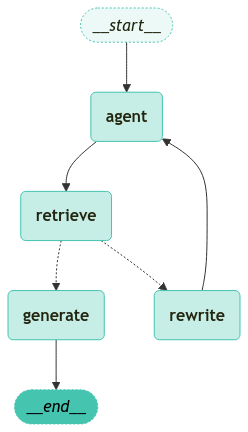

In [4]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(watson.graph)

In [4]:
watson._vectorstore.as_retriever(search_kwargs={"k": 6}).invoke(input="ÏßÄÏó≠")

[Document(id='5d74f6e0-b522-4cc4-98ba-cba02a9abb1c', metadata={'id': 108, 'timestamp': datetime.datetime(2023, 7, 29, 6, 5, 37), 'chats': '', 'views': 1005, 'url': 'https://t.me/frozen_talk/108', 'database': 'retriever-jisung', 'collection': 'channel_data'}, page_content='-Îñ® Î∂ÄÏÇ∞ Î∞è Í¥ëÏ£ºÎßå Í∞ÄÎä•\n Ï†Ñ ÏßÄÏó≠ ÌíàÏ†à\n(Ïû¨ÏûÖÍ≥†Ïãú Í≥µÏßÄÏòàÏ†ï)'),
 Document(id='bb6e8f07-ef02-4df7-afd1-1d279a32288f', metadata={'id': 44, 'timestamp': datetime.datetime(2023, 5, 15, 12, 33, 31), 'chats': '', 'views': 1069, 'url': 'https://t.me/frozen_talk/44', 'database': 'retriever-jisung', 'collection': 'channel_data'}, page_content='Í∞ïÏÑú ÏßÄÏó≠ Ï¢åÌëú Ï∂îÍ∞ÄÎêêÏäµÎãàÎã§\nÍ∑∏ÎèôÏïà Í∞ïÎÇ®Ïù¥ Î©ÄÏñ¥ÏÑú Íµ¨Îß§\nÎ™ªÌïòÏÖ®Îçò Î∂ÑÎì§ ÎßéÏù¥ Ï∞æÏïÑÏ£ºÏÑ∏Ïöî!'),
 Document(id='4bdbdffd-a278-41ed-8144-b2505758abf9', metadata={'id': 224, 'timestamp': datetime.datetime(2024, 6, 1, 12, 55, 7), 'chats': '', 'views': 2191, 'url': 'https://t.me/frozen_talk/224', 'database': 'retriever-jisung', 'collection': '